### Packages

In [31]:
#packages
import numpy as np
import scipy.linalg as la
import networkx as nx 
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pickle


mpl.rcParams['font.family'] = 'serif' #'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

### Complete graph Hamiltonian

In [32]:
def H_CG(N, gamma, w, kappa):
    """
    Generate the Hamiltonian for search on the Complete Graph with a sink at target site.
    
    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: The resulting Hamiltonian in matrix form.
    """
    ket_s = np.ones((N, 1)) / np.sqrt(N) # Initial state (uniform superposition)
    H = -gamma * N * ket_s @ ket_s.T.conj() # Hamiltonian matrix of complete graph
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)


### Eigenvalues and Eigenvectors (theoretically)

In [3]:
def lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambda_plus (float): Eigenenergy of the form a + b
        lambda_minus (float): Eigenenergy of the form a - b
    """
    

    lambda_plus  = -(gamma*N + 1 + 1.0j*kappa)/2  + np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))
    lambda_minus = -(gamma*N + 1 + 1.0j*kappa)/2  - np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))

    return lambda_plus,lambda_minus

def imag_lambda_pm(N,gamma,kappa):

    """
    Compute the analytical expresion of the imaginary part of the eigenvalues in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        imag_lambda_plus (float): Imaginary part of eigenvalue lambda_plus
        imag_lambda_minus (float): Imaginary part of eigenvalue lambda_minus
    """
    
   # a  = ((gamma*N + 1)**2 - kappa**2)/4 - (gamma*N - gamma)
    a = 1/4 + gamma - N*gamma/2 + N*N*gamma*gamma/4 - kappa*kappa/4
    b  = kappa/2 + gamma*kappa - N*gamma*kappa/2
    mod_z = (1/4)*np.sqrt(4*(kappa*kappa)*(-1 + (N-2)*gamma)**2 + (-1 +2*(N - 2)*gamma - N*N*gamma*gamma + kappa*kappa)**2)
    #mod_z = np.sqrt(a**2 + b**2)

    imag_lambda_plus = - kappa/2 + np.sign(b)*np.sqrt((mod_z - a)/2)
    imag_lambda_minus = - kappa/2 - np.sign(b)*np.sqrt((mod_z - a)/2)

    return imag_lambda_plus, imag_lambda_minus

def lambdaR(N,gamma,kappa):

    """
    Compute the analytical expresion of the right eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaR_plus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaR_minus (np.ndarray): Right eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """   

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- lambda_plus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaR_plus = np.array([a_plus,b_plus])

    a_minus = (- lambda_minus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaR_minus = np.array([a_minus,b_minus])

    return lambdaR_plus, lambdaR_minus


def lambdaL(N,gamma,kappa):

    """
    Compute the analytical expresion of the left eigenvectors in the two dimensional subspace.

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        lambdaL_plus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_plus (column vector)
        lambdaL_minus (np.ndarray): Left eigenvector corresponding to eigenvalue lambda_minus (column vector)
    """  

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- np.conj(lambda_plus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaL_plus = np.array([a_plus,b_plus])

    a_minus = (- np.conj(lambda_minus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaL_minus = np.array([a_minus,b_minus])

    return lambdaL_plus, lambdaL_minus



### Overlaps

In [33]:
def overlap(N,gamma,kappa):

    """
    Compute the analytical expresion of the overlaps with initial uniform superposition state. The overlaps corresponds to each term
    in the analytical expression of survival probability (see text for more details). 

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.

    Returns:
        overlap_plus (float): Overlap correspond to the decay rate governed by Im[lambda_plus].
        overlap_minus (float): Overlap correspond to the decay rate governed by Im[lambda_minus].
        overlap_pm (complex): Overlap correspond to the term having cross terms from both eigenvalues.
    """  

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    #initial state
    ket_s = np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    #overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    #overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)

    return overlap_plus, overlap_minus,overlap_pm

### Survival Probability (2D space) without reset

In [34]:
def surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa):

    """
    Compute the survival probability as a function of time analytically in two-dimensional basis without any reset.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
 
    m = int(Tcutoff / dt)  # Number of time steps, each with duration dt

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlaps 
    overlap_plus, overlap_minus,overlap_pm = overlap(N,gamma,kappa)
   
    s_prob = np.zeros(m) # Initialize array

    for j in range(m): 
        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*j*dt)*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*j*dt)*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*j*dt)*overlap_pm)

        s_prob[j] = first_term + second_term +third_term


    return s_prob

### Find the survival probablity decay time 

In [35]:
def find_transition_point(arr, dt,tp): 
    """
    Find the first time index where the survival probability (SP) drops below tp.
    
    Args:
        arr (numpy array): Array of survival probability values.
        dt (float): Discretization of time into time steps of duration dt.
        
    Returns:
        float: Time at which SP drops below the value of tp.
    """
    idx = np.where(arr <= tp)[0]
    return idx[0] * dt if len(idx) > 0 else 0  # Return first occurrence or 0

### Fix N, $\kappa = \kappa_{opt}$ compute the $t_{decay}$ to 0.001 (sensitivity of the optimal parameters)

In [170]:
# Parameters
Tcutoff = 3600
dt = 0.05
kappa = kappa_opts[15]
N = NList[15]  # System size
gamma_vals = np.linspace(0.9/N, 1.1/N, 100)

# Storage Arrays
T_decay0p001N3 = np.zeros(len(gamma_vals))
s_prob_arr = np.zeros((len(gamma_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
   # for kk, kappa in enumerate(kappa_vals):      
    s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
    s_prob_arr[gg] = s_prob
    T_decay0p001N3[gg] = find_transition_point(s_prob, dt,0.001)
            
#filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2090512/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


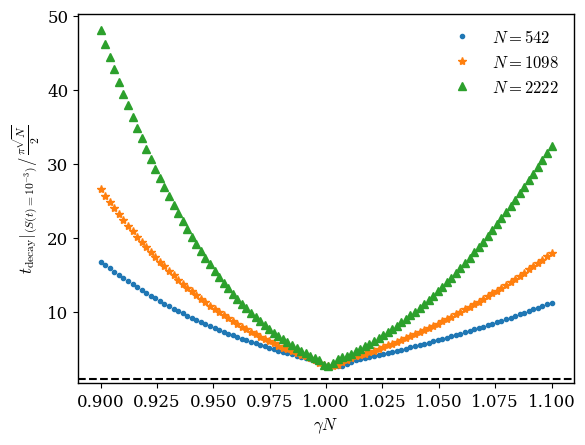

In [77]:
gamma_vals1 = np.linspace(0.9/NList[12], 1.1/NList[12], 100)
Tcoh_opt1 = (np.pi/2)*np.sqrt(NList[12])

gamma_vals2 = np.linspace(0.9/NList[17], 1.1/NList[17], 100)
Tcoh_opt2 = (np.pi/2)*np.sqrt(NList[17])

gamma_vals3 = np.linspace(0.9/NList[22], 1.1/NList[22], 100)
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[22])

plt.plot(gamma_vals1*NList[12], T_decay0p001N1/Tcoh_opt1,'.',label = f'$N ={int(NList[12])} $')
plt.plot(gamma_vals2*NList[17], T_decay0p001N2/Tcoh_opt2,'*',label = f'$N ={int(NList[17])} $')
plt.plot(gamma_vals3*NList[22], T_decay0p001N3/Tcoh_opt3,'^',label = f'$N ={int(NList[22])} $')

plt.axhline(1, ls = '--',color = 'k')
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$t_{\text{decay}}\vert_{(S(t) = 10^{-3})}/\,\frac{\pi \sqrt{N}}{2}$')

plt.legend(frameon = False)

#plt.savefig(r'prefactor_gammaN_no_resetting.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

In [162]:
6*np.pi/7

2.6927937030769655

In [171]:
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[15])

np.min(T_decay0p001N3/Tcoh_opt3)



np.float64(2.6902864825974575)

In [93]:
np.argmin(T_decay0p001N2/Tcoh_opt2)


np.int64(50)

In [94]:
np.argmin(T_decay0p001N3/Tcoh_opt3)

np.int64(50)

In [172]:
# Parameters

prefac = np.zeros(len(NList[:23]))


for nn in range(len(NList[:23])):
    Tcutoff = 3600
    dt = 0.05
    kappa = kappa_opts[nn]
    N = NList[nn]  # System size
    gamma_vals = np.linspace(0.9/N, 1.1/N, 100)

    Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[nn])


    # Storage Arrays
    T_decay0p001N3 = np.zeros(len(gamma_vals))
    s_prob_arr = np.zeros((len(gamma_vals), int(Tcutoff / dt)))

    # Compute Survival Probabilities and Transition Points
    for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    # for kk, kappa in enumerate(kappa_vals):      
        s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
        s_prob_arr[gg] = s_prob
        T_decay0p001N3[gg] = find_transition_point(s_prob, dt,0.001)
    

    prefac[nn] = np.min(T_decay0p001N3/Tcoh_opt3)
            
#filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2090512/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


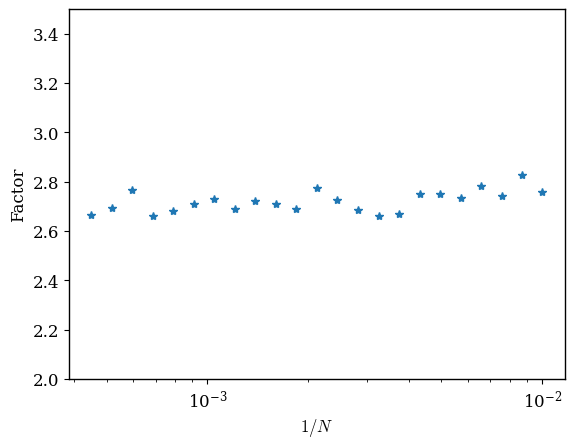

In [179]:
plt.plot(1.0/NList[:23], prefac,'*')

plt.ylabel(r'Factor')
plt.xlabel(r'$1/N$')
plt.ylim(2,3.5)
plt.xscale('log')

plt.savefig('prefac.pdf',bbox_inches = 'tight')
plt.show()

### Fix N, $\gamma = \gamma_{opt}$ compute the $t_{decay}$ to 0.001 (sensitivity of the optimal parameters)

In [101]:
# Parameters
Tcutoff = 3600
dt = 0.05
kappa_vals = np.linspace(0, 0.4, 100)
N = NList[22]  # System size
gamma = gamma_vals3[50]

# Storage Arrays
T_decay0p001N3_k = np.zeros(len(kappa_vals))
s_prob_arr = np.zeros((len(kappa_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, kappa in tqdm(enumerate(kappa_vals), total=len(kappa_vals)):
   # for kk, kappa in enumerate(kappa_vals):      
    s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
    s_prob_arr[gg] = s_prob
    T_decay0p001N3_k[gg] = find_transition_point(s_prob, dt,0.001)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1601183/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


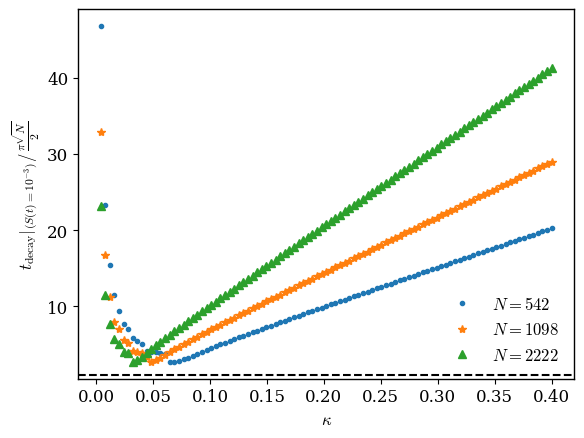

In [103]:
kappa_vals = np.linspace(0, 0.4, 100)
Tcoh_opt1 = (np.pi/2)*np.sqrt(NList[12])
Tcoh_opt2 = (np.pi/2)*np.sqrt(NList[17])
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[22])


plt.plot(kappa_vals[1:], T_decay0p001N1_k[1:]/Tcoh_opt1,'.',label = f'$N ={int(NList[12])} $')
plt.plot(kappa_vals[1:], T_decay0p001N2_k[1:]/Tcoh_opt2,'*',label = f'$N ={int(NList[17])} $')
plt.plot(kappa_vals[1:], T_decay0p001N3_k[1:]/Tcoh_opt3,'^',label = f'$N ={int(NList[22])} $')

plt.axhline(1, ls = '--',color = 'k')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$t_{\text{decay}}\vert_{(S(t) = 10^{-3})}/\,\frac{\pi \sqrt{N}}{2}$')

plt.legend(frameon = False)

#plt.savefig(r'prefactor_kappa_no_resetting.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

### $t_{decay}$ to 0.001 in $(N- \gamma N)$ plane at $\kappa_{opt}$

In [120]:
# Parameters
Tcutoff = 3600
dt = 0.05

T_decay0p001_arr = np.zeros((len(NList[:23]),len(gamma_vals)))

for nn in range(len(NList[:23])):

    kappa = kappa_opts[nn]
    Decoherence Cancellation through Noise Interference
Giuseppe D’Auria ,
1 Giovanna Morigi ,
2 Fabio Anselmi ,
3, 4 and Fabio BenatN = NList[nn]  # System size
    gamma_vals = np.linspace(0.9/N, 1.1/N, 100)

    # Storage Arrays

    s_prob_arr = np.zeros((len(NList[:23]),len(gamma_vals), int(Tcutoff / dt)))

    # Compute Survival Probabilities and Transition Points
    for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    # for kk, kappa in enumerate(kappa_vals):      
        s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
        s_prob_arr[nn,gg] = s_prob
        T_decay0p001_arr[nn,gg] = find_transition_point(s_prob, dt,0.001)/((np.pi/2)*np.sqrt(N))

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1601183/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


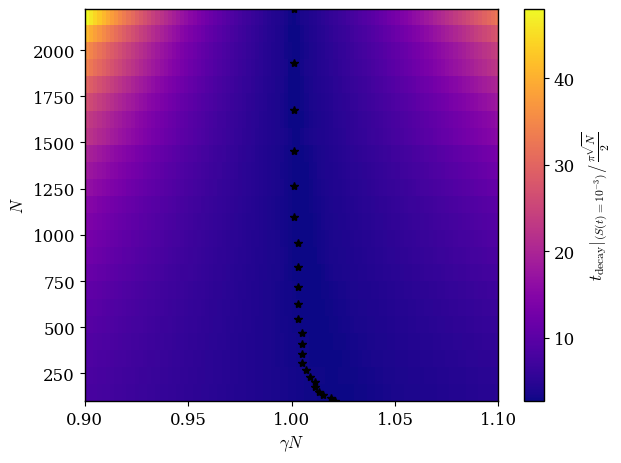

In [146]:
N_vals = NList[:23]

gamma_rescaled = np.linspace(0.9, 1.1, 100)  # same for all rows

# Create meshgrid in rescaled variables
GammaTilde, Ngrid = np.meshgrid(gamma_rescaled, N_vals)

# Plot
#plt.figure(figsize=(10, 6))

cp = plt.imshow(T_decay0p001_arr, extent=[0.9, 1.1, N_vals[0], N_vals[-1]], aspect='auto', origin='lower', cmap='plasma')
#cp = plt.pcolormesh(GammaTilde, Ngrid, T_decay_normalized, levels=50, cmap='plasma')
plt.colorbar(cp, label=r'$t_{\text{decay}}\vert_{(S(t) = 10^{-3})}/\,\frac{\pi \sqrt{N}}{2}$')

for i in range(len(NList[:23])):
    plt.plot( gamma_rescaled[np.argmin(T_decay0p001_arr[i])],NList[i],'k*')


plt.xlabel(r'$\gamma N$')e^{- \frac{t}{\sqrt{N}} } 
#plt.savefig(r'PD_gammaN_no_resetting.pdf',bbox_inches ='tight', dpi = 800)
plt.show()

In [23]:
import numpy as np
c = 0.001
np.log(2/c)/(np.pi)

np.float64(2.419442396790935)

In [148]:
gamma_rescaled_opt = np.zeros(len(NList[:23]))
for i in range(len(NList[:23])):
    gamma_rescaled_opt[i] = gamma_rescaled[np.argmin(T_decay0p001_arr[i])]

### $t_{decay}$ to 0.001 in $(N- \kappa)$ plane at $\gamma_{opt}$

In [169]:
# Parameters
Tcutoff = 3600
dt = 0.05

# Storage Arrays
T_decay0p001_arr_k = np.zeros((len(NList[:23]),len(kappa_vals)))


for nn in range(len(NList[:23])):

    kappa_vals = np.linspace(0, 0.4, 100)
    N = NList[nn]  # System size
    gamma = gamma_rescaled_opt[nn]/N

    s_prob_arr = np.zeros((len(NList[:23]),len(kappa_vals), int(Tcutoff / dt)))

    # Compute Survival Probabilities and Transition Points
    for gg, kappa in tqdm(enumerate(kappa_vals), total=len(kappa_vals)):
    # for kk, kappa in enumerate(kappa_vals):      
        s_prob = surv_prob_theory_total(Tcutoff, dt, N, gamma, kappa)
        s_prob_arr[nn,gg] = s_prob
        T_decay0p001_arr_k[nn,gg] = find_transition_point(s_prob, dt,0.001)/((np.pi/2)*np.sqrt(N))

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1601183/733383813.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = first_term + second_term +third_term
100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


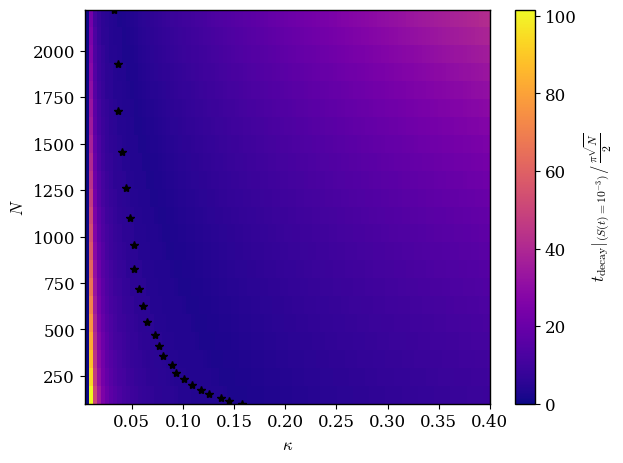

In [174]:
N_vals = NList[:23]

kappa_vals = np.linspace(0, 0.4, 100)

# Create meshgrid in rescaled variables
kappaTilde, Ngrid = np.meshgrid(kappa_vals[1:], N_vals)

# Plot
#plt.figure(figsize=(10, 6))

cp = plt.imshow(T_decay0p001_arr_k[1:,:], extent=[kappa_vals[1], 0.4, N_vals[0], N_vals[-1]], aspect='auto', origin='lower', cmap='plasma')
#cp = plt.pcolormesh(GammaTilde, Ngrid, T_decay_normalized, levels=50, cmap='plasma')
plt.colorbar(cp, label=r'$t_{\text{decay}}\vert_{(S(t) = 10^{-3})}/\,\frac{\pi \sqrt{N}}{2}$')

for i in range(len(NList[:23])):
    plt.plot( kappa_vals[np.argmin(T_decay0p001_arr_k[i][1:])+1],NList[i],'k*')


plt.xlabel(r'$\kappa$')
plt.ylabel('$N$')
#plt.yscale('log')

plt.tight_layout()


plt.savefig(r'PD_kappa_no_resetting.pdf',bbox_inches ='tight', dpi = 800)
plt.show()

### Survival probability in presence of deterministic resetting

In [7]:
def overlap_reset(N,gamma,kappa,ket_s):

    """
    Compute the analytical expresion of the overlaps with initial uniform superposition state. The overlaps corresponds to each term
    in the analytical expression of survival probability (see text for more details). 

    Args:
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        ket_s (np.ndarray): the reset state

    Returns:
        overlap_plus (float): Overlap correspond to the decay rate governed by Im[lambda_plus].
        overlap_minus (float): Overlap correspond to the decay rate governed by Im[lambda_minus].
        overlap_pm (complex): Overlap correspond to the term having cross terms from both eigenvalues.
    """  

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    #overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    #overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)

    return overlap_plus, overlap_minus,overlap_pm



In [8]:

def surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa):
    
    """
    Compute the survival probability as a function of time using analytics in two dimensional basis. Here reset is done using
    deterministic protocol to the initial state.
    
    Args:
        Tcutoff (float): Cutoff time for the dynamics.
        dt (float): Discretization of time into time steps of duration dt.
        r (int): reset value (such that the time after which we reset is t_reset = r*dt).
        N (int): Number of nodes in complete graph (system size).
        gamma (float): Prefactor scaling the QWer evolution; controls the 'hopping strength'. Optimum for CD at gamma*N = 1.
        w (int): Target node/site location; dynamics invariant under choice of w.
        kappa (float): Loss rate / strength of incoherent term in the oracle part of the Hamiltonian.
        
    Returns:
        np.ndarray: Survival probabilities.
    """
  
    m = int(Tcutoff / dt)
    s_prob_reset = np.zeros(m)

    # Initial state
    initial_state =np.array([1.0/np.sqrt(N), np.sqrt((N-1)/N)])
    reset_state = initial_state.copy()

    # Set initial survival probability
    s_prob_reset[0] = 1
    #has_crossed_half_decay = False

    # Precompute eigenvalues and deltas
    lambda_plus, lambda_minus = lambda_pm(N, gamma, kappa)
    overlap_plus, overlap_minus, overlap_pm = overlap_reset(N, gamma, kappa, reset_state)

    t_r = 0

    for j in range(1, m):

        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*(j*dt -t_r))*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*(j*dt -t_r))*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*(j*dt -t_r))*overlap_pm)

        s_prob_reset[j] = np.real(first_term + second_term + third_term)

        # If survival probability crossed below 0.5, activate reset logic
        #if not has_crossed_half_decay and s_prob_reset[j-1] < 0.5:
            #has_crossed_half_decay = True

        #if has_crossed_half_decay and r != 0 and j % r == 0:
        if r != 0 and j % r == 0:
            t_r =  j*dt
            reset_state = np.sqrt(s_prob_reset[j])* np.array([1.0/np.sqrt(N), np.sqrt((N-1)/N)])
            overlap_plus, overlap_minus, overlap_pm = overlap_reset(N, gamma, kappa, reset_state)
            #print(overlap_plus + overlap_minus + 2*np.real(overlap_pm), s_prob_reset[j])

    return s_prob_reset

### Fix N, $\kappa = \kappa_{opt}$, find the optimum reset rate and the corresponding $t^r_{decay}$

In [93]:
# Parameters
kappa = kappa_opts[12]
N = NList[12] # System size

Tcutoff = 3600 # cutoff time increasing with square root of N
dt = 0.05

r_vals = np.linspace(0, (Tcutoff+1)/10/dt, 50, dtype=int)

gamma_vals = np.linspace(0.9/N, 1.1/N, 20)

# Storage Arrays
r_opt1_ = np.zeros(len(gamma_vals))
T_decay_reset1_ = np.zeros((len(gamma_vals), len(r_vals)))
s_prob_det_reset = np.zeros((len(gamma_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and transition
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    #for kk, kappa in enumerate(kappa_vals):
    for rr, r in tqdm(enumerate(r_vals)):
        s_prob_theory = surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa)
        s_prob_det_reset[gg, rr] = s_prob_theory
        T_decay_reset1_[gg, rr] = find_transition_point(s_prob_theory, dt, 0.001)

#filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay_reset]
#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

50it [00:12,  4.09it/s]00:00<?, ?it/s]
50it [00:12,  4.08it/s]00:12<03:52, 12.21s/it]
50it [00:12,  4.08it/s]00:24<03:40, 12.24s/it]
50it [00:12,  4.12it/s]00:36<03:28, 12.25s/it]
50it [00:12,  4.10it/s]00:48<03:15, 12.20s/it]
50it [00:12,  4.09it/s]01:01<03:03, 12.20s/it]
50it [00:12,  4.12it/s]01:13<02:50, 12.21s/it]
50it [00:12,  4.13it/s]01:25<02:38, 12.19s/it]
50it [00:12,  4.11it/s]01:37<02:25, 12.16s/it]
50it [00:12,  4.10it/s]01:49<02:13, 12.17s/it]
50it [00:12,  4.12it/s][02:01<02:01, 12.17s/it]
50it [00:12,  4.12it/s][02:14<01:49, 12.16s/it]
50it [00:12,  4.13it/s][02:26<01:37, 12.15s/it]
50it [00:12,  4.11it/s][02:38<01:24, 12.14s/it]
50it [00:12,  4.11it/s][02:50<01:12, 12.15s/it]
50it [00:12,  4.10it/s][03:02<01:00, 12.16s/it]
50it [00:12,  4.12it/s][03:14<00:48, 12.17s/it]
50it [00:12,  4.14it/s][03:26<00:36, 12.16s/it]
50it [00:12,  4.13it/s][03:39<00:24, 12.13s/it]
50it [00:12,  4.10it/s][03:51<00:12, 12.13s/it]
100%|██████████| 20/20 [04:03<00:00, 12.17s/it]


In [87]:
Tr_optN3 = np.zeros(len(gamma_vals))
Tr_no_resetN3 = np.zeros(len(gamma_vals))

T_decay_reset3[:,1] = 50000
T_decay_reset3[:,2] = 50000

for i in range(len(gamma_vals)):
    diffs = T_decay_reset3[i] - T_decay_reset3[i][0]
    min_j = np.argmin(diffs)
    if diffs[min_j] < diffs[0]:
        j = min_j
    else:
        j = 0
    r_opt3[i] = r_vals[j]
    Tr_optN3[i] = T_decay_reset3[i][j]
    Tr_no_resetN3[i] = T_decay_reset3[i][0]

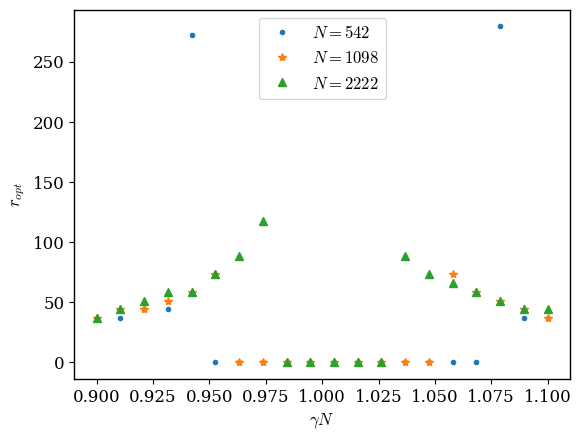

In [99]:
plt.plot(gamma_vals1*NList[12], r_opt1_*dt,'.',label = f'$N = {int(NList[12])}$')

plt.plot(gamma_vals2*NList[17], r_opt2*dt,'*',label = f'$N = {int(NList[17])}$')

plt.plot(gamma_vals3*NList[22], r_opt3*dt,'^',label = f'$N = {int(NList[22])}$')

plt.legend()

plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$r_{opt}$')

plt.savefig(r'det_reset_opt_gammaN.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

In [70]:
Tr_optN2 = np.zeros(len(gamma_vals))
Tr_no_resetN2 = np.zeros(len(gamma_vals))

T_decay_reset2[:,1] = 50000

for i in range(len(gamma_vals)):
    diffs = T_decay_reset2[i] - T_decay_reset2[i][0]
    min_j = np.argmin(diffs)
    if diffs[min_j] < diffs[0]:
        j = min_j
    else:
        j = 0
    r_opt2[i] = r_vals[j]
    Tr_optN2[i] = T_decay_reset2[i][j]
    Tr_no_resetN2[i] = T_decay_reset2[i][0]

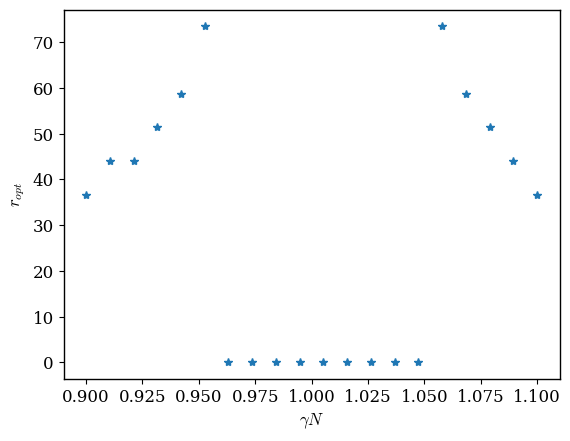

In [71]:
plt.plot(gamma_vals*NList[17], r_opt2*dt,'*')

plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$r_{opt}$')

plt.show()

In [94]:
Tr_optN1_ = np.zeros(len(gamma_vals))
Tr_no_resetN1_ = np.zeros(len(gamma_vals))

for i in range(len(gamma_vals)):
    diffs = T_decay_reset1_[i] - T_decay_reset1_[i][0]
    min_j = np.argmin(diffs)
    if diffs[min_j] < diffs[0]:
        j = min_j
    else:
        j = 0
    r_opt1_[i] = r_vals[j]
    Tr_optN1_[i] = T_decay_reset1_[i][j]
    Tr_no_resetN1_[i] = T_decay_reset1_[i][0]

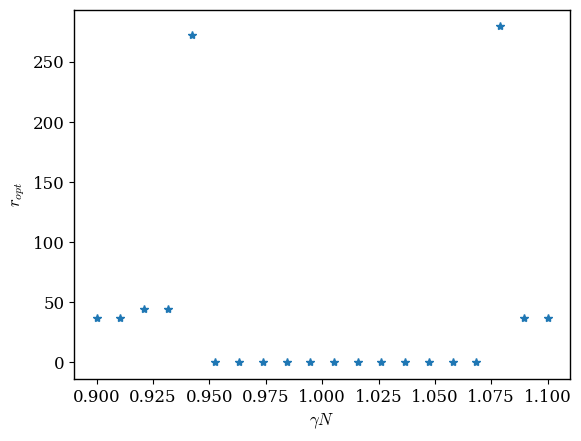

In [95]:
plt.plot(gamma_vals*NList[12], r_opt1_*dt,'*')

plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$r_{opt}$')

plt.show()

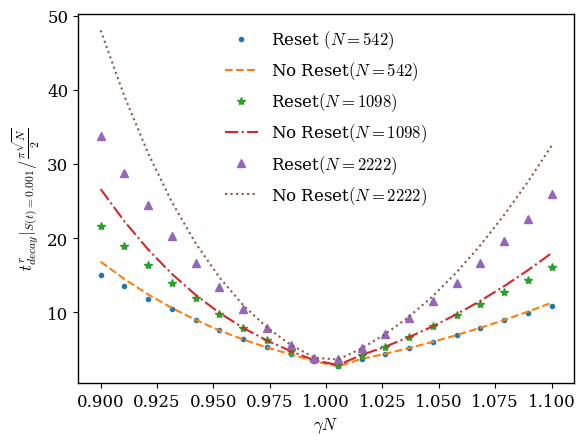

In [97]:
gamma_vals1 = np.linspace(0.9/NList[12], 1.1/NList[12], 20)
gamma_vals2 = np.linspace(0.9/NList[17], 1.1/NList[17], 20)
gamma_vals3 = np.linspace(0.9/NList[22], 1.1/NList[22], 20)

Tcoh_opt1 = (np.pi/2)*np.sqrt(NList[12])
Tcoh_opt2 = (np.pi/2)*np.sqrt(NList[17])
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[22])


plt.plot(gamma_vals1*NList[12], Tr_optN1_/Tcoh_opt1,'.',label = f'Reset $(N = {int(NList[12])})$')
plt.plot(gamma_vals1*NList[12], Tr_no_resetN1_/Tcoh_opt1,'--', label = f'No Reset$(N = {int(NList[12])})$')

plt.plot(gamma_vals2*NList[17], Tr_optN2/Tcoh_opt2,'*',label = f'Reset$(N = {int(NList[17])})$')
plt.plot(gamma_vals2*NList[17], Tr_no_resetN2/Tcoh_opt2,'-.', label = f'No Reset$(N = {int(NList[17])})$')

plt.plot(gamma_vals3*NList[22], Tr_optN3/Tcoh_opt3,'^',label = f'Reset$(N = {int(NList[22])})$')
plt.plot(gamma_vals3*NList[22], Tr_no_resetN3/Tcoh_opt3,':', label = f'No Reset$(N = {int(NList[22])})$')



plt.legend(frameon = False)

plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$t^r_{decay}\vert_{S(t) = 0.001} / \, \frac{\pi \sqrt{N}}{2}$')

#plt.savefig(r'det_reset_comparision_N123_gammaN.pdf',bbox_inches = 'tight', dpi = 600)
plt.show()

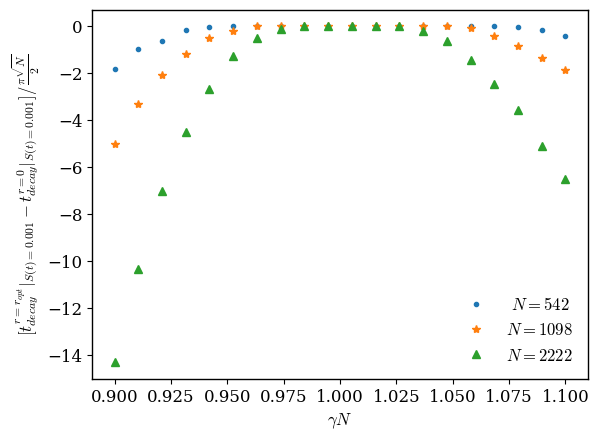

In [109]:
gamma_vals1 = np.linspace(0.9/NList[12], 1.1/NList[12], 20)
gamma_vals2 = np.linspace(0.9/NList[17], 1.1/NList[17], 20)
gamma_vals3 = np.linspace(0.9/NList[22], 1.1/NList[22], 20)

Tcoh_opt1 = (np.pi/2)*np.sqrt(NList[12])
Tcoh_opt2 = (np.pi/2)*np.sqrt(NList[17])
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[22])


plt.plot(gamma_vals1*NList[12], (Tr_optN1_ - Tr_no_resetN1_)/Tcoh_opt1,'.',label = f' $N = {int(NList[12])}$')
#plt.plot(gamma_vals1*NList[12], Tr_no_resetN1_/Tcoh_opt1,'--', label = f'No Reset$(N = {int(NList[12])})$')

plt.plot(gamma_vals2*NList[17], (Tr_optN2 -Tr_no_resetN2)/Tcoh_opt2,'*',label = f'$N = {int(NList[17])}$')
#plt.plot(gamma_vals2*NList[17], Tr_no_resetN2/Tcoh_opt2,'-.', label = f'No Reset$(N = {int(NList[17])})$')

plt.plot(gamma_vals3*NList[22], (Tr_optN3 - Tr_no_resetN3)/Tcoh_opt3,'^',label = f'$N = {int(NList[22])}$')
#plt.plot(gamma_vals3*NList[22], Tr_no_resetN3/Tcoh_opt3,':', label = f'No Reset$(N = {int(NList[22])})$')



plt.legend(frameon = False)

plt.xlabel(r'$\gamma N$')
plt.ylabel(r'$[t^{r = r_{opt}}_{decay}\vert_{S(t) = 0.001}  - t^{r = 0}_{decay}\vert_{S(t) = 0.001}] / \, \frac{\pi \sqrt{N}}{2}$')

plt.savefig(r'diff_det_reset_comparision_N123_gammaN.pdf',bbox_inches = 'tight', dpi = 600)
plt.show()

In [110]:
np.argmin(Tr_no_resetN1_)

np.int64(10)

In [114]:
np.argmin(Tr_no_resetN2)

np.int64(10)

In [115]:
np.argmin(Tr_no_resetN3)

np.int64(10)

### Fix N, $\gamma = \gamma_{opt}$, find the optimum reset rate and the corresponding $t^r_{decay}$ as a function of $\kappa$

In [138]:
# Parameters
kappa_vals =  np.linspace(0, 0.2, 20)
N = NList[22] # System size

Tcutoff = 3600 # cutoff time increasing with square root of N
dt = 0.05

r_vals = np.linspace(0, (Tcutoff+1)/10/dt, 50, dtype=int)

gamma = gamma_vals3[10]

# Storage Arrays
r_opt3_k = np.zeros(len(kappa_vals))
T_decay_reset3_k = np.zeros((len(kappa_vals), len(r_vals)))
s_prob_det_reset = np.zeros((len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and transition
for gg, kappa in tqdm(enumerate(kappa_vals), total=len(kappa_vals)):
    #for kk, kappa in enumerate(kappa_vals):
    for rr, r in tqdm(enumerate(r_vals)):
        s_prob_theory = surv_prob_det_reset(Tcutoff, dt, r, N, gamma, kappa)
        s_prob_det_reset[gg, rr] = s_prob_theory
        T_decay_reset3_k[gg, rr] = find_transition_point(s_prob_theory, dt, 0.001)

#filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_reset.pkl"
#dict_to_save = [gamma_vals, kappa_vals, r_vals, T_decay_reset]
#with open(filename, 'wb') as f:
#    pickle.dump(dict_to_save, f)

50it [00:12,  4.12it/s]00:00<?, ?it/s]
50it [00:11,  4.18it/s]00:12<03:50, 12.13s/it]
50it [00:12,  4.13it/s]00:24<03:36, 12.03s/it]
50it [00:12,  4.13it/s]00:36<03:25, 12.07s/it]
50it [00:12,  4.12it/s]00:48<03:13, 12.08s/it]
50it [00:12,  4.11it/s]01:00<03:01, 12.10s/it]
50it [00:12,  4.15it/s]01:12<02:49, 12.13s/it]
50it [00:12,  4.14it/s]01:24<02:37, 12.10s/it]
50it [00:12,  4.16it/s]01:36<02:25, 12.10s/it]
50it [00:12,  4.15it/s]01:48<02:12, 12.07s/it]
50it [00:12,  4.14it/s][02:00<02:00, 12.07s/it]
50it [00:12,  4.11it/s][02:12<01:48, 12.07s/it]
50it [00:12,  4.10it/s][02:25<01:36, 12.10s/it]
50it [00:12,  4.10it/s][02:37<01:24, 12.13s/it]
50it [00:12,  4.15it/s][02:49<01:12, 12.15s/it]
50it [00:12,  4.12it/s][03:01<01:00, 12.12s/it]
50it [00:12,  4.13it/s][03:13<00:48, 12.12s/it]
50it [00:11,  4.17it/s][03:25<00:36, 12.12s/it]
50it [00:12,  4.12it/s][03:37<00:24, 12.08s/it]
50it [00:12,  4.13it/s][03:49<00:12, 12.10s/it]
100%|██████████| 20/20 [04:02<00:00, 12.10s/it]


In [139]:
T_decay_reset3_k_modified = np.where(T_decay_reset3_k == 0, 1e10, T_decay_reset3_k)

In [140]:
Tr_optN3_k = np.zeros(len(kappa_vals))
Tr_no_resetN3_k = np.zeros(len(kappa_vals))



for i in range(len(kappa_vals)):
    diffs = T_decay_reset3_k_modified[i] - T_decay_reset3_k_modified[i][0]
    min_j = np.argmin(diffs)
    if diffs[min_j] < diffs[0]:
        j = min_j
    else:
        j = 0
    r_opt3_k[i] = r_vals[j]
    Tr_optN3_k[i] = T_decay_reset3_k_modified[i][j]
    Tr_no_resetN3_k[i] = T_decay_reset3_k_modified[i][0]

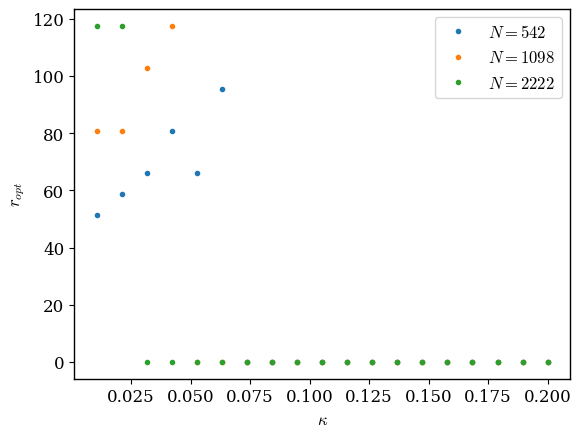

In [153]:
plt.plot(kappa_vals[1:], r_opt1_k[1:]*dt,'.',label = f'$N = {int(NList[12])}$')
plt.plot(kappa_vals[1:], r_opt2_k[1:]*dt,'.',label = f'$N = {int(NList[17])}$')
plt.plot(kappa_vals[1:], r_opt3_k[1:]*dt,'.',label = f'$N = {int(NList[22])}$')


#plt.plot(gamma_vals3*NList[22], r_opt3*dt,'^',label = f'$N = {int(NList[22])}$')

plt.legend()

plt.xlabel(r'$\kappa$')
plt.ylabel(r'$r_{opt}$')

plt.savefig(r'det_reset_opt_kappa.pdf',bbox_inches = 'tight', dpi = 800)

plt.show()

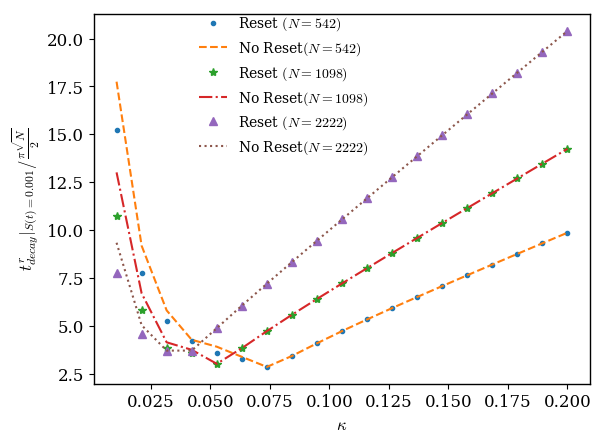

In [154]:
Tcoh_opt1 = (np.pi/2)*np.sqrt(NList[12])
Tcoh_opt2 = (np.pi/2)*np.sqrt(NList[17])
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[22])


plt.plot(kappa_vals[1:], Tr_optN1_k[1:]/Tcoh_opt1,'.',label = f'Reset $(N = {int(NList[12])})$')
plt.plot(kappa_vals[1:], Tr_no_resetN1_k[1:]/Tcoh_opt1,'--', label = f'No Reset$(N = {int(NList[12])})$')

plt.plot(kappa_vals[1:], Tr_optN2_k[1:]/Tcoh_opt2,'*',label = f'Reset $(N = {int(NList[17])})$')
plt.plot(kappa_vals[1:], Tr_no_resetN2_k[1:]/Tcoh_opt2,'-.', label = f'No Reset$(N = {int(NList[17])})$')

plt.plot(kappa_vals[1:], Tr_optN3_k[1:]/Tcoh_opt3,'^',label = f'Reset $(N = {int(NList[22])})$')
plt.plot(kappa_vals[1:], Tr_no_resetN3_k[1:]/Tcoh_opt3,':', label = f'No Reset$(N = {int(NList[22])})$')


plt.legend(frameon = False, fontsize = 10, loc = (0.2,0.6))

plt.xlabel(r'$\kappa$')
plt.ylabel(r'$t^r_{decay}\vert_{S(t) = 0.001} / \, \frac{\pi \sqrt{N}}{2}$')

plt.savefig(r'det_reset_comparision_N123_kappa.pdf',bbox_inches = 'tight', dpi = 600)
plt.show()

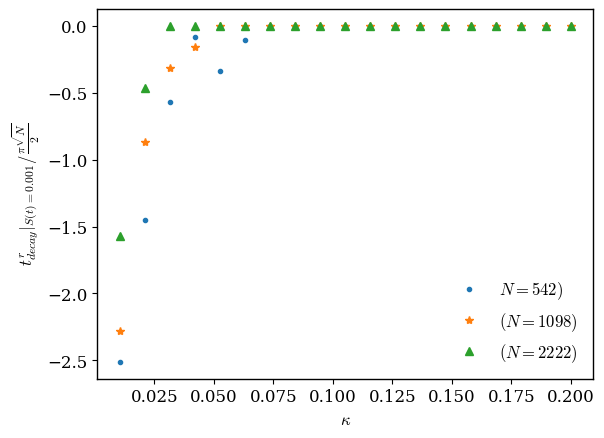

In [157]:
Tcoh_opt1 = (np.pi/2)*np.sqrt(NList[12])
Tcoh_opt2 = (np.pi/2)*np.sqrt(NList[17])
Tcoh_opt3 = (np.pi/2)*np.sqrt(NList[22])


plt.plot(kappa_vals[1:], (Tr_optN1_k[1:] -Tr_no_resetN1_k[1:]) /Tcoh_opt1,'.',label = f'$N = {int(NList[12])})$')
#plt.plot(kappa_vals[1:], Tr_no_resetN1_k[1:]/Tcoh_opt1,'--', label = f'No Reset$(N = {int(NList[12])})$')

plt.plot(kappa_vals[1:], (Tr_optN2_k[1:]-Tr_no_resetN2_k[1:])/Tcoh_opt2,'*',label = f'$(N = {int(NList[17])})$')
#plt.plot(kappa_vals[1:], Tr_no_resetN2_k[1:]/Tcoh_opt2,'-.', label = f'No Reset$(N = {int(NList[17])})$')

plt.plot(kappa_vals[1:], (Tr_optN3_k[1:] -Tr_no_resetN3_k[1:])/Tcoh_opt3,'^',label = f'$(N = {int(NList[22])})$')
#plt.plot(kappa_vals[1:], Tr_no_resetN3_k[1:]/Tcoh_opt3,':', label = f'No Reset$(N = {int(NList[22])})$')


plt.legend(frameon = False)

plt.xlabel(r'$\kappa$')
plt.ylabel(r'$t^r_{decay}\vert_{S(t) = 0.001} / \, \frac{\pi \sqrt{N}}{2}$')

plt.savefig(r'diff_det_reset_comparision_N123_kappa.pdf',bbox_inches = 'tight', dpi = 600)
plt.show()

### Survival Probability with Stochastic resetting protocol

In [ ]:
def sample_reset_step(r_mean_steps, max_step):
    while True:
        step = int(np.random.exponential(scale=r_mean_steps))
        if step < max_step:
            return step

def surv_prob_stochastic_reset(Tcutoff, dt, r_mean, N, gamma, kappa,T_half):
    m = int(Tcutoff / dt)
    s_prob_reset = np.zeros(m)

    # Initial state 
    initial_state =  np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])
    reset_state = initial_state.copy()
    s_prob_reset[0] = 1

    # Precompute eigenvalues
    lambda_plus, lambda_minus = lambda_pm(N, gamma, kappa)

    # Initial overlaps
    overlap_plus, overlap_minus, overlap_pm = overlap_reset(N, gamma, kappa, reset_state)

    r_mean_steps = r_mean / dt
    max_step =  T_half
    next_reset_step = sample_reset_step(r_mean_steps, max_step)

    t_r = 0

    for j in range(1, m):

        first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*(j*dt -t_r))*overlap_plus
        second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*(j*dt -t_r))*overlap_minus
        third_term  = 2*np.real(np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*(j*dt -t_r))*overlap_pm)

        s_prob_reset[j] = np.real(first_term + second_term + third_term)

        
        if j == next_reset_step:
            
            t_r = j * dt
            reset_state = np.sqrt(s_prob_reset[j])* np.array([1.0/np.sqrt(N), np.sqrt((N-1)/N)])
            overlap_plus, overlap_minus, overlap_pm = overlap_reset(N, gamma, kappa, reset_state)

            next_reset_step = j + sample_reset_step(r_mean_steps, max_step)
            
            if next_reset_step >= m:
                next_reset_step = m  #reset to end

    return s_prob_reset

### Optimum parameters from the half decay

In [9]:
# Parameters
NList =  np.floor(np.logspace(2,5,50))# System size


runtimes = np.zeros(len(NList))
gammaN_opts = np.zeros(len(NList))
kappa_opts = np.zeros(len(NList))

for j, N in enumerate(NList):

    Tcutoff = 2*np.sqrt(N)
    dt = 0.05

    filename = f"../Data/Data_Log/survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}_NO_SPROB_theory.pkl"
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    gamma_vals, kappa_vals, r_vals, T_decay0p5_theory = data

    T_min_theory = np.zeros((len(gamma_vals), len(kappa_vals)))
    T_decay0p5_theory = np.where(T_decay0p5_theory==0, np.inf, T_decay0p5_theory)

    for gg in tqdm(range(len(gamma_vals))):
        for kk in range(len(kappa_vals)):
            T_decay_temp = T_decay0p5_theory[gg, kk]
            if len(T_decay_temp) > 0:
                T_min_theory[gg, kk] = np.min(T_decay_temp)
                #r_optimal[gg, kk] = r_vals[np.argmin(T_decay_temp)]
            else:
                T_min_theory[gg, kk] = np.nan  # Mark undefined cases
                #r_optimal[gg, kk] = np.nan

    id = np.unravel_index(T_min_theory.argmin(), T_min_theory.shape)
    runtimes[j] = T_min_theory[np.unravel_index(T_min_theory.argmin(), T_min_theory.shape)]
    gammaN_opts[j] = gamma_vals[id[0]]*N
    kappa_opts[j] = kappa_vals[id[1]]

100%|██████████| 100/100 [00:00<00:00, 6676.38it/s]
